# Analysis of 103k entries from the WOS

State of OA dataset

**Results are not 100% correct (some FB engagement numbers are missing) as some errors occured in the data collection**

Will be eventually updated if we run the fixed script again for this data.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from pprint import pprint

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

plt.rcParams["figure.figsize"] = (9,5)

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [3]:
full_df = pd.read_csv("PKP_temp.csv", encoding = 'utf8')
df_dates = pd.read_csv("data/input_files/PKP_20171220.csv", encoding = 'utf8').drop_duplicates()
full_df = full_df.merge(df_dates, on="doi").set_index("doi")
full_df['date'] = pd.to_datetime(full_df.date)
full_df['year'] = full_df.date.apply(lambda x: x.year)
full_df['fb_share_count'] = full_df.fb_share_count.map(lambda x: np.nan if x == 0 else x)

# Table of Contents

## Bad rows (DOI resolve errors, URL-OG mapping errors)

ATM 25k rows are removed because of:

+ Remove bad urls (if resolved URL appears more than once in the results -> removed)
+ Remove entries with DOI resolve errors
+ Remove all entries with identical OG IDs
+ Exclude papers before 2008 and after 2015


## Some stats

**Frequencies**

Few stats for number of found articles across platform, years, and OA status

+ [Frequencies across years](#Frequencies-across-years)

**Shares**

Stats for the average number of shares across platform , years, and OA status.
Median numbers not included as they are quite boring (lots of 0 shares for FB, lots of 1 shares for Altmetric)

+ [Average shares across years](#Average-shares-across-years)

**Correlations**

+ [Correlation](#Correlation)

# Bad rows

In [4]:
total = len(full_df)
print(total)
df = full_df[full_df['doi_resolve_status'] == "200"]
print(total - len(df))
total = len(df)

df = df[~(~df.fb_og_id.isnull() & df.duplicated(subset=['fb_og_id'], keep=False))]
print(total - len(df))
total = len(df)

df = df[~df.duplicated(subset=['doi_url'], keep=False)]
print(total - len(df))
total = len(df)

min_year = 2010
max_year = 2018
df = df[df['year'].between(min_year, max_year)]
print(total - len(df))
total = len(df)

print(total)

285036
83741
4579
2821
61133
132762


In [5]:
# Transformed dataframe for year/oa_color_long/platform plotting
pdf = df[['year', 'am_share_count', 'fb_share_count']].melt(id_vars = ['year'], var_name="platform", value_name="shares")
df[['year', 'am_share_count', 'fb_share_count']];

## Frequencies across years

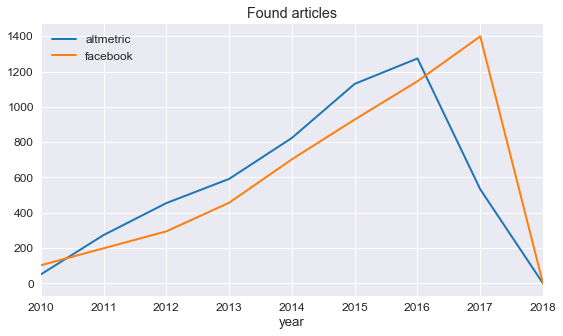

In [7]:
df.groupby(['year'])[['am_share_count', 'fb_share_count']].count().plot();
# plt.xlim([min_year, max_year]);
plt.gca().legend(labels=["altmetric", "facebook"]);
plt.title("Found articles");

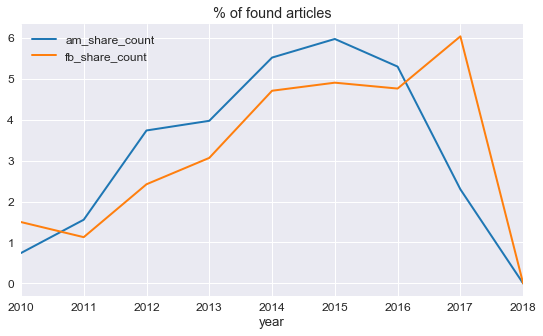

In [8]:
a = df.groupby(['year']).count()
(100*a[['am_share_count', 'fb_share_count']].divide(a.date,0)).plot();
plt.title("% of found articles");

In [9]:
df[['doi_url', 'am_share_count', 'fb_share_count']].dropna().describe()

,am_share_count,fb_share_count
count,654.000000,654.000000
mean,2.544343,3.914373
std,12.285664,8.892863
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,276.000000,136.000000


In [25]:
df[df.am_share_count > 50].iloc[0].url

'http://www.foodandnutritionresearch.net/index.php/fnr/article/view/31694'

In [193]:
x = df[['doi_url', 'am_share_count', 'fb_share_count']].fillna(0)
x = x[(x.am_share_count > 0) | (x.fb_share_count > 0)]
d = x.fb_share_count -  x.am_share_count
print(len(d[d>0]))
print(len(d[d<0]))
print(len(d[d==0]))
print(len(d))

d.describe()

4878
4567
263
9708


count    9708.000000
mean        0.566646
std         6.485729
min      -243.000000
25%        -1.000000
50%         1.000000
75%         1.000000
max       310.000000
dtype: float64

In [194]:
# FB > Altmetric
d[d>0].describe()

count    4878.000000
mean        2.755228
std         7.303712
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       310.000000
dtype: float64

In [196]:
# FB < AM
d[d<0].describe()

count    4567.00000
mean       -1.73834
std         4.69033
min      -243.00000
25%        -2.00000
50%        -1.00000
75%        -1.00000
max        -1.00000
dtype: float64

## Average shares across years

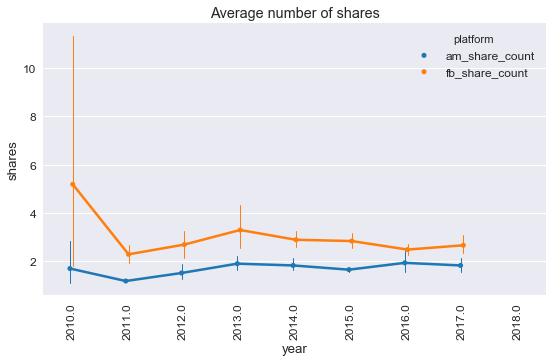

In [191]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");
plt.xticks(rotation=90);

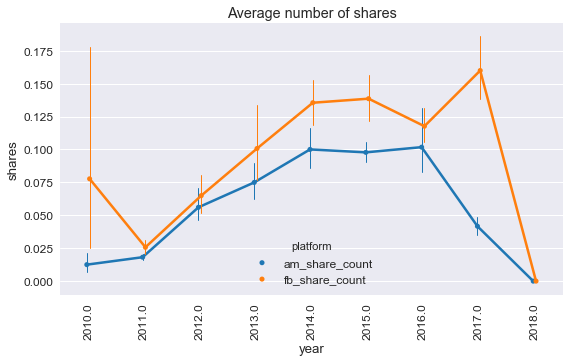

In [197]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf.fillna(0),
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");
plt.xticks(rotation=90);

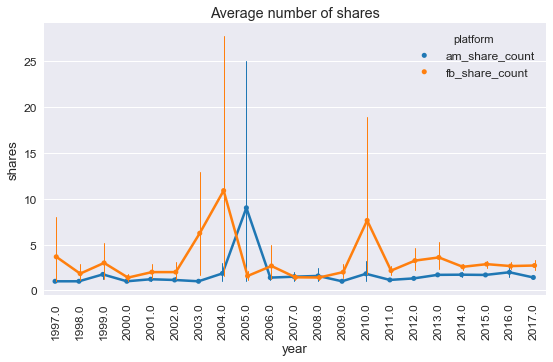

In [89]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf[pdf.shares != 0],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

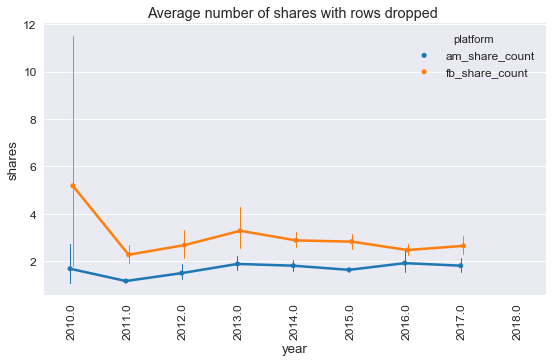

In [198]:
temp = pdf
temp.loc[pdf['shares'] == 0, 'shares'] = 1
sns.pointplot(x="year", y="shares", hue="platform", data=temp,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares with rows dropped ");
plt.xticks(rotation=90);

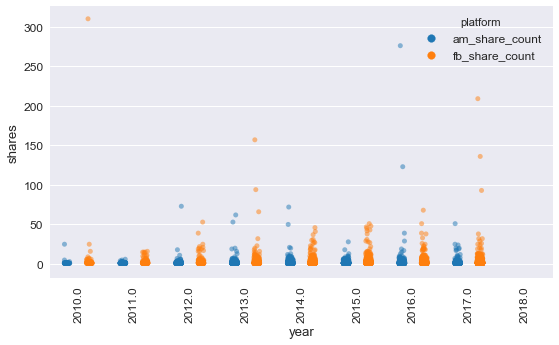

In [199]:
sns.stripplot(x="year", y="shares", hue="platform", data=pdf, jitter=True, dodge=True, alpha=.5);
plt.xticks(rotation=90);

In [204]:
df[df['diff'] < -45]

,timestamp,doi_resolve_status,doi_resolve_error,doi_url,fb_response_error,am_response_error,fb_og_id,fb_share_count,fb_reaction_count,fb_comment_plugin_count,fb_comment_count,am_id,am_score,am_share_count,date,url,year,diff
doi,,,,,,,,,,,,,,,,,,
10.3402/fnr.v60.31694,2017-12-16 00:01:27.924448,200,None,http://www.tandfonline.com/doi/full/10.3402/fn...,None,None,1.502623e+15,33.0,89.0,0.0,55.0,12440377.0,954.936,276.0,2016-09-27,http://www.foodandnutritionresearch.net/index....,2016.0,-243.0
10.3402/ejpt.v5.25097,2017-12-16 00:15:10.773637,200,None,http://www.tandfonline.com/doi/full/10.3402/ej...,None,None,1.347580e+15,1.0,0.0,0.0,0.0,2741638.0,58.706,50.0,2014-09-15,http://www.ejpt.net/index.php/ejpt/article/vie...,2014.0,-49.0
10.3402/fnr.v60.32527,2017-12-19 17:01:02.780057,200,None,http://www.tandfonline.com/doi/full/10.3402/fn...,None,None,1.569038e+15,23.0,93.0,0.0,84.0,15866853.0,424.930,123.0,2016-11-22,http://www.foodandnutritionresearch.net/index....,2016.0,-100.0


(-20, 20)

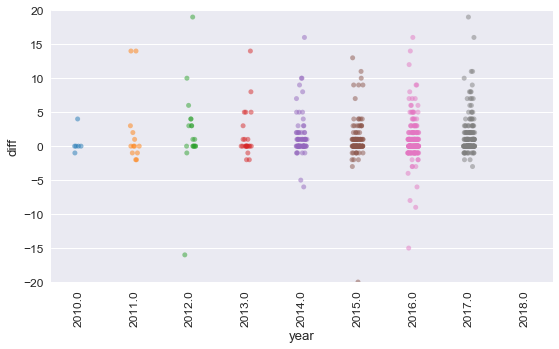

In [208]:
sns.stripplot(x="year", y="diff", data=df, jitter=True, dodge=True, alpha=.5);
plt.xticks(rotation=90);
plt.ylim(-20,20)

(-50, 50)

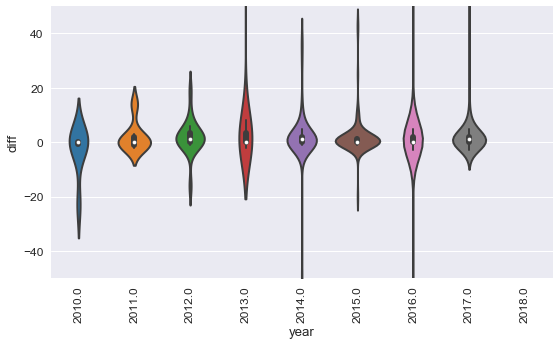

In [206]:
sns.violinplot(x="year", y="diff", data=df, jitter=True, dodge=True, alpha=.5);
plt.xticks(rotation=90);
plt.ylim(-50,50)

## Correlation

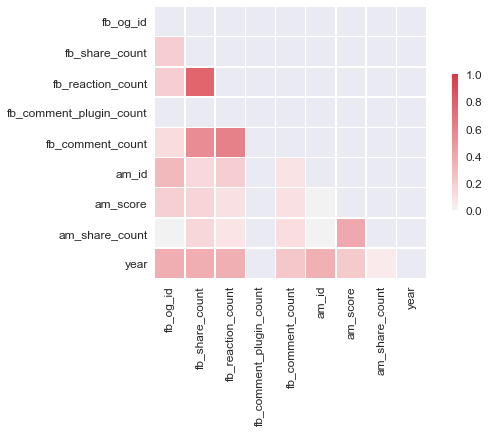

In [54]:
corr = df.corr(method = "spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})